### Game Description:
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.
    
Acions :  
    0 - Push to the Left  
    1 - Push to the Right  
    
States :  
    0 - Cart Position (-2.4, +2.4)  
    1 - cart Velocity  
    2 - Pole Angle (-41.8d , + 41.8d)  
    4 - Pole Velocity at Tip  
    
Termination State:  
    Pole Angle is more than ±12°  
    Cart Position is more than ±2.4 (center of the cart reaches the edge of the display)

#### Deep Q Learning
   DQL is a model free off policy reinforcement learning algorithm which can be used to solve any problem that follows markov decission process. 
    
We must have known so far that in Q-Learning RL algorithm we create a Q-Table of Q values for each state action pair. And for each episode, each time step agent finds the next action for a state from the Q table. then we update the Q-Value in the Q-Table. This approach is good when environment has less number of states . In case of complex environment when it has many number of states and actions then periodically finding Q table and updating Q table for state action pair is computationaly expensive.
    
Deep Q Learning helps to resolve this problem of Q-Learning. Deep Q Learning combines the neural network with Q-Learning algorithm. Instead of having a big Q table , the DQL uses artificial neural network to predict the next action for a given state and also to find optimal Q value for state action pair. Three important concepts involved are -

> **Experience Replay** : In Deep Q Learning, we need to define a memory buffer of capacity N to hold all previous experiences of agent. Suppose Agent take an action and performs it. It will receive reward , next state etc. We store this info as a tuple known as 'Experience' into memory buffer called 'Replay Memory'. Experinece is a tuple as (Current state, action, reward, next state). Neural network is trained on sample experiences taken from Replay memory.

> **Policy Net** : It is a deep neural network which is used to predict the next action that agent can take from a specific state. This network is trained on experiences of agent randomly sampled from Replay Memory.

> **Target Net** : It is a clone of Policy Net used to find max Q value for next states when an agent reached to next state taking action from current state. This network is not trained with experiences of agent. It is just used to predict Q Values for next state. After certain time steps the weights of this network is updated from the weights of policy network.
    
Lets write the steps involved in DQL,
    
1. Create Environment Object
2. initialize all hyperparameters such as epsilon, gamma, number_of_episodes etc.
3. Create Replay Memory of predefined capacity
4. Build and Compile a Deep Neural Network Model - Policy Net
5. Clone the Policy Net into neural Network 'Target Net'
6. for each episode
    1. initialize starting state
    2. While not a terminate state
        - Find Strategy (Exploration or Exploitation)
        - Select Action through epsilon greedy strategy
        - Perform Action
        - Store an experience (state, action, reward, next_state) in replay memory
        - Update state to next state
        - After X time step Target Net weights to the weights of Policy Net
    3. Train Policy Net
        - Take random sample of experience of specific batch size ,from replay Memory
        - Pass next state to terget net to predict Max Q Value
        - Calculate Reward
        - Update Target Q Values        
        - train Policy Net with current state and Target Q value 
    
    4. Update Epsilon

In [1]:
# Importing Libraries
import gym
import numpy as np
import random
from collections import deque
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
env = gym.make('CartPole-v0')
env.reset()
print('Number of Possible Actions ', env.action_space.n)

Number of Possible Actions  2


In [3]:
#Replay Memory
replay_memory = deque(maxlen=20000)

In [4]:
#DQN - Policy Network
import tensorflow as tf
policy_net = tf.keras.models.Sequential()
policy_net.add(tf.keras.layers.Dense(24, input_shape=(4,), activation='relu'))
policy_net.add(tf.keras.layers.Dense(24, activation='relu'))
policy_net.add(tf.keras.layers.Dense(2, activation='linear'))
policy_net.compile(loss='mse', optimizer='adam',metrics=['accuracy'])

In [5]:
#DQN - Target Network
target_net = tf.keras.models.clone_model(policy_net)
target_net.set_weights(policy_net.get_weights())

In [6]:
def train_dqn(replay_memory, batch_size):
    
    # Take Sample of Size=batch_size
    if len(replay_memory) < batch_size:
        return
    
    sample_experience = random.sample(replay_memory, batch_size)
    
    
    # Current States
    state_array = [exp[0] for exp in sample_experience]
    state_array = np.concatenate(state_array,axis=0)
    
    # Rewards
    rewards = [exp[2] for exp in sample_experience]
    
    # Next States
    next_state_aray = [exp[3] for exp in sample_experience]
    next_state_aray = np.concatenate(next_state_aray, axis=0)
        
    # Actions
    actions = [exp[1] for exp in sample_experience]
    action_array = np.array(actions)
    
    # Target Q-Value (Passing Next State to the Policy Network)
    max_q_vals = [np.amax(target_net.predict(np.reshape(s,[1,4]))) for s in next_state_aray]
    
    target_q_vals = rewards + 0.99 * np.array(max_q_vals)
    actual_q_vals = policy_net.predict(np.reshape(s,[1,4]) for s in state_array)
    
    for row,col in zip(range(len(action_array)),action_array):
        actual_q_vals[row,col] = target_q_vals[row]
    
    # Fit the State and Actual Q Value (Target Q value) into the Model : Trainging
    policy_net.fit(state_array, actual_q_vals, epochs=1, verbose=0)
    

In [ ]:
epsilon_ = 1
results = []
for episode in range(1000):
    state = env.reset()
    state = np.reshape(state, [1,4])
    done = False
    total_reward = 0
    time_step = 0
    exp_or_use = ''
    while not done:
        
        env.render()
        #Exploration-Exploitation Trade Off
        #Finding Action
        exp_th = random.uniform(0,1)
        if exp_th <= epsilon_:
            exp_or_use = 'Exploring'
            action = env.action_space.sample()
        else:
            exp_or_use = 'Exploiting'
            action = np.argmax(policy_net.predict(state))
            
        #Taking Action
        next_state, reward, done, info = env.step(action)
        next_state = np.reshape(next_state, [1,4])
        
        #Store Experience -> Replay Memory
        experience = (state, action, reward, next_state)
        replay_memory.append(experience)
        
        state = next_state
        total_reward += reward
        time_step += 1

        #After Evry 10 time Steps update target_net wights
        if time_step > 15 and (time_step % 15 == 0):
            target_net.set_weights(policy_net.get_weights())
            
    print('Episode : ', episode,' **** Exp/Use : ',exp_or_use,' **** Reward : ', total_reward ,' **** Time Step ', time_step)
    results.append([episode, time_step])  
    
    #Train DQN Model
    train_dqn(replay_memory, 200)
    
    #Decaying Exploration Rate
    epsilon_ = 0.01 + (1 - 0.01)* np.exp(- 0.001 * episode)
    
env.close()

(10, 78)

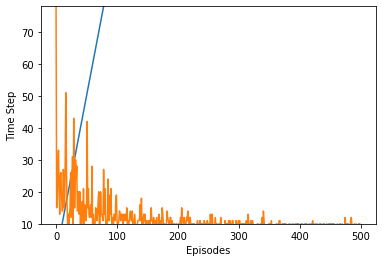

In [35]:
# Plot Results. X-EPisode Count , Y = Score/Time Step
result_data = pd.DataFrame(results) 
plt.plot(result_data)
plt.xlabel('Episodes')
plt.ylabel('Time Step')
plt.ylim((10,result_data[1].max()))
